# Projections of network activity in 3D PC space

In [1]:
import sys
import os

import brainpy as bp
import brainpy.math as bm

from types import SimpleNamespace
from utils import *
from calc_params import par, update_parameters

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

%matplotlib ipympl


Initializing Parameters...


In [2]:
f_dir = "test_output_full_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

In [3]:
stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)
prep_h_mat.shape

(280, 200)

In [4]:
mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

In [5]:
pca_mt = PCA(n_components=3)
pca_mt.fit(mt_h)

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)

pca_all = PCA(n_components=3)
pca_all.fit(prep_h_mat)

PCA(n_components=3)

In [6]:
activity_dict_mt = [normalized_h[:, i, mt_idx] for i in range(normalized_h.shape[1])]
activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]
activity_dict_all = [normalized_h[:, i, :] for i in range(normalized_h.shape[1])]

In [7]:
def draw_projections(activity_dict, pca, indices, ground_truth_arr, color_dict, title):
    plt.rcdefaults()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18, 5))
    # fig = plt.figure(figsize = (8,8))
    # ax = plt.axes(projection='3d')
    # ax = plt.axes()
    for i in indices[:100]:
        activity_pc = pca.transform(activity_dict[i])
        # ground_truth = out[i]
        ground_truth = ground_truth_arr[i]
        # color = 'red' if ground_truth == 0 else 'blue'
        color = list(color_dict.values())[0] if ground_truth == list(color_dict.keys())[0] else list(color_dict.values())[1]
        ax1.plot(activity_pc[:25, 0], activity_pc[:25, 1], '-', color='gray', alpha=0.6)
        ax1.plot(activity_pc[25:45, 0], activity_pc[25:45, 1], '-', color='cyan', alpha=0.6)
        ax1.plot(activity_pc[45:, 0], activity_pc[45:, 1],'-', color=color, alpha=0.6)
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')

        ax2.plot(activity_pc[:25, 0], activity_pc[:25, 2], '-', color='gray', alpha=0.6)
        ax2.plot(activity_pc[25:45, 0], activity_pc[25:45, 2], '-', color='cyan', alpha=0.6)
        ax2.plot(activity_pc[45:, 0], activity_pc[45:, 2],'-', color=color, alpha=0.6)
        ax2.set_xlabel('PC1')
        ax2.set_ylabel('PC3')

        ax3.plot(activity_pc[:25, 1], activity_pc[:25, 2], '-', color='gray', alpha=0.6)
        ax3.plot(activity_pc[25:45, 1], activity_pc[25:45, 2], '-', color='cyan', alpha=0.6)
        ax3.plot(activity_pc[45:, 1], activity_pc[45:, 2],'-', color=color, alpha=0.6)
        ax3.set_xlabel('PC2')
        ax3.set_ylabel('PC3')
        
    plt.suptitle(title)

color_dict_out = {0: 'orange', 1: "blue"}
color_dict_stim = {135: 'green', 315: "red"}

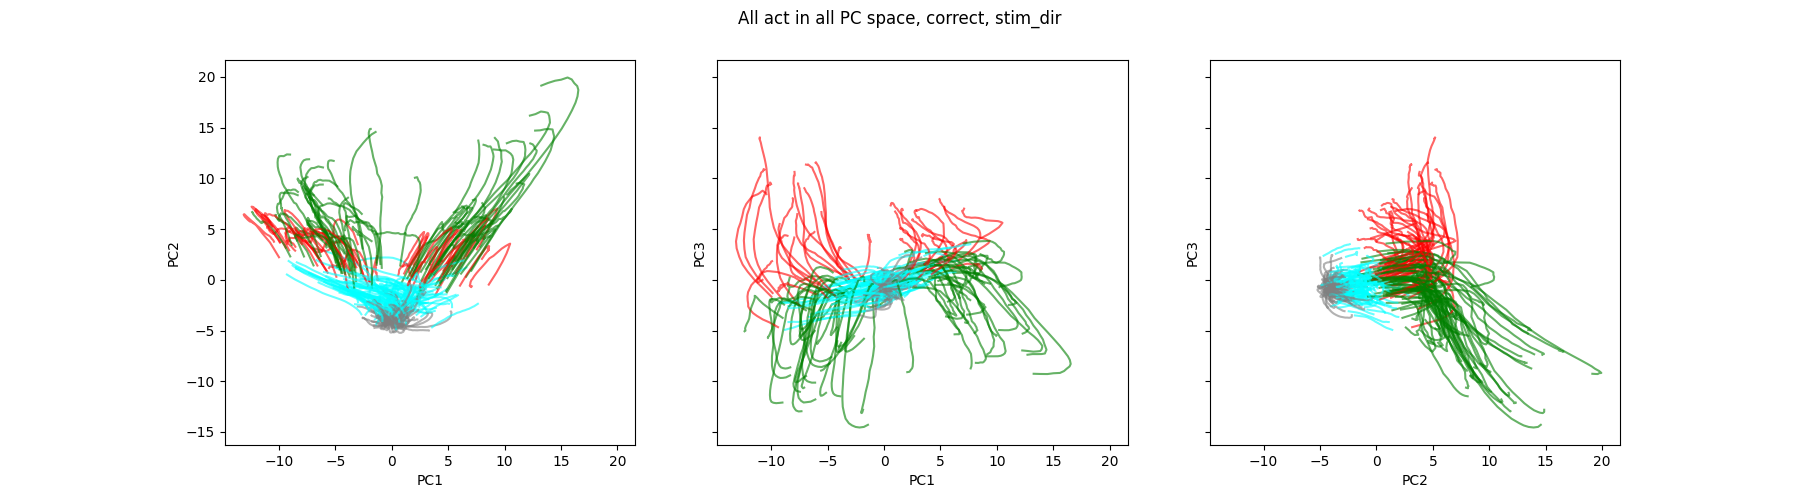

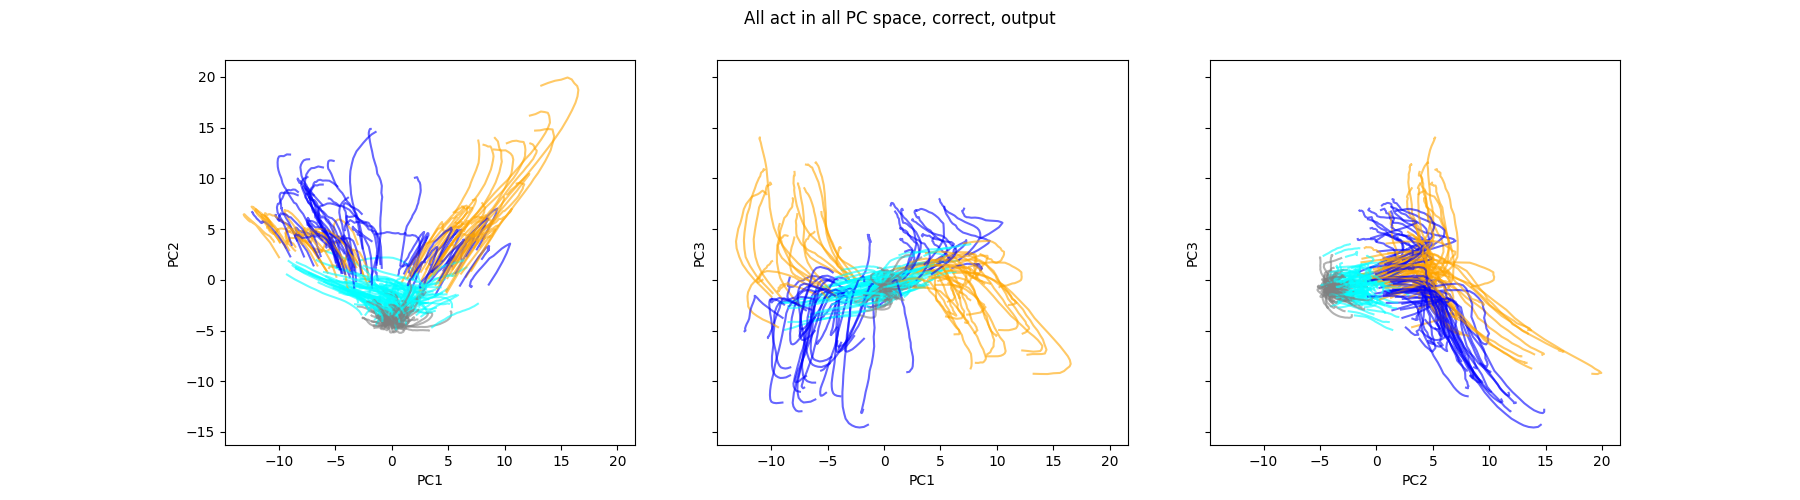

In [9]:
draw_projections(activity_dict_all, pca_all, correct_idx, stim_dir, color_dict_stim, "All act in all PC space, correct, stim_dir")
draw_projections(activity_dict_all, pca_all, correct_idx, out, color_dict_out, "All act in all PC space, correct, output")

## Target activity in target PC space

In [ ]:
draw_projections(activity_dict_mt, pca_mt, correct_idx, stim_dir, color_dict_stim, "Target act in target space, correct, stim_dir")
draw_projections(activity_dict_mt, pca_mt, correct_idx, out, color_dict_out, "Target act in target space, correct, output")

In [ ]:
draw_projections(activity_dict_mt, pca_mt, incorrect_idx, stim_dir, color_dict_stim, "Target act in target space, incorrect, stim_dir")
draw_projections(activity_dict_mt, pca_mt, incorrect_idx, out, color_dict_out, "Target act in target space, incorrect, output")

## Motion activity in motion PC space

In [ ]:
draw_projections(activity_dict_mm, pca_mm, correct_idx, stim_dir, color_dict_stim, "Motion act in motion space, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, correct_idx, out, color_dict_out, "Motion act in motion space, correct, output")

In [ ]:
draw_projections(activity_dict_mm, pca_mm, incorrect_idx, stim_dir, color_dict_stim, "Motion act in motion space, incorrect, stim_dir")
draw_projections(activity_dict_mm, pca_mm, incorrect_idx, out, color_dict_out, "Motion act in motion space, incorrect, output")

## Motion activity in target PC space (correct only)

In [ ]:
draw_projections(activity_dict_mm, pca_mt, correct_idx, stim_dir, color_dict_stim, "Motion act in target space, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mt, correct_idx, out, color_dict_out, "Motion act in target space, correct, output")

## Target activity in motion PC space (correct only)

In [ ]:
draw_projections(activity_dict_mt, pca_mm, correct_idx, stim_dir, color_dict_stim, "Target act in motion space, correct, stim_dir")
draw_projections(activity_dict_mt, pca_mm, correct_idx, out, color_dict_out, "Target act in motion space, correct, output")

## Further analysis of motion activity in motion space, separated by stimulus coherence

In [ ]:
Z_idx = np.where(np.logical_and(np.array(n.stim_level) == b'Z', n.correct_idx))[0]
L_idx = np.where(np.logical_and(np.array(n.stim_level) == b'L', n.correct_idx))[0]
M_idx = np.where(np.logical_and(np.array(n.stim_level) == b'M', n.correct_idx))[0]
H_idx = np.where(np.logical_and(np.array(n.stim_level) == b'H', n.correct_idx))[0]

### Zero

In [ ]:
draw_projections(activity_dict_mm, pca_mm, Z_idx, stim_dir, color_dict_stim, "Motion act in motion space, Z coh, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, Z_idx, out, color_dict_out, "Motion act in motion space, Z coh, correct, output")

### Low

In [ ]:
draw_projections(activity_dict_mm, pca_mm, L_idx, stim_dir, color_dict_stim, "Motion act in motion space, L coh, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, L_idx, out, color_dict_out, "Motion act in motion space, L coh, correct, output")

### Medium

In [ ]:
draw_projections(activity_dict_mm, pca_mm, M_idx, stim_dir, color_dict_stim, "Motion act in motion space, M coh, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, M_idx, out, color_dict_out, "Motion act in motion space, M coh, correct, output")

### High

In [ ]:
draw_projections(activity_dict_mm, pca_mm, H_idx, stim_dir, color_dict_stim, "Motion act in motion space, H coh, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, H_idx, out, color_dict_out, "Motion act in motion space, H coh, correct, output")

## The influence of feedback: Activity projections when specific feedback connections were cut

In [ ]:
f_dir = "cutSpec_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)

mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)

activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]


In [ ]:
draw_projections(activity_dict_mm, pca_mm, correct_idx, stim_dir, color_dict_stim, "Motion act in motion space, cut specific feedback, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, correct_idx, out, color_dict_out, "Motion act in motion space, cut specific feedback, correct, output")

## The influence of feedback: Activity projections when non-specific feedback connections were cut

In [ ]:
f_dir = "cutNonspec_model"
lr = 0.02
rep = 0
update_parameters({'rep': rep,
                    'save_fn': 'model_results_%d_lr%f.pkl' % (rep, lr),
                    'batch_size': par['test_batch_size'],
                    'num_iterations': par['num_test_iterations'],
                    'coherence_levels': par['test_coherence_levels'],
                    'weight_fn': 'weight_%d.pth' % (rep),
                    'learning_rate': lr, 
                    'save_test_out': False})
n = SimpleNamespace(**load_test_data(f_dir, "test_output_lr%f_rep%d.h5" % (lr, rep)))
normalized_h = min_max_normalize(n.h)

stim_dir = n.stim_dir
reshaped_out =  n.desired_out[-1, :, :]
out = [0 if reshaped_out[i, 0] == 1 else 1 for i in range(reshaped_out.shape[0])]
cond1_idx = np.logical_and(stim_dir==135, np.array(out)==0)
cond2_idx = np.logical_and(stim_dir==135, np.array(out)==1)
cond3_idx = np.logical_and(stim_dir==315, np.array(out)==0)
cond4_idx = np.logical_and(stim_dir==315, np.array(out)==1)

cond1_h = np.mean(normalized_h[:, cond1_idx, :], axis=1)
cond2_h = np.mean(normalized_h[:, cond2_idx, :], axis=1)
cond3_h = np.mean(normalized_h[:, cond3_idx, :], axis=1)
cond4_h = np.mean(normalized_h[:, cond4_idx, :], axis=1)

prep_h_mat = np.concatenate((cond1_h, cond2_h, cond3_h, cond4_h), axis=0)

mt_idx = np.concatenate([range(40, 80), range(120, 160), range(170, 180), range(190, 200)])
mm_idx = np.concatenate([range(40), range(80, 120), range(160, 170), range(180, 190)])
# m_idx = np.arange(200)
mt_h = prep_h_mat[:, mt_idx]
mm_h = prep_h_mat[:, mm_idx]

correct_idx =  np.where(n.correct_idx)[0]
incorrect_idx = np.where(~n.correct_idx)[0]

pca_mm = PCA(n_components=3)
pca_mm.fit(mm_h)

activity_dict_mm = [normalized_h[:, i, mm_idx] for i in range(normalized_h.shape[1])]


In [ ]:
draw_projections(activity_dict_mm, pca_mm, correct_idx, stim_dir, color_dict_stim, "Motion act in motion space, cut non-specific feedback, correct, stim_dir")
draw_projections(activity_dict_mm, pca_mm, correct_idx, out, color_dict_out, "Motion act in motion space, cut non-specific feedback, correct, output")